# Protein Synthesis Simulation

Load dataset:

In [1]:
from HumanGenomeDataset.load_dataset import load_dataset

data_df = load_dataset('dna_protein_coding_sequences')
data_df.head(2)

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,ID,sequence,category
0,NM_001368254.1,GCTGAGCTGAGCTGGGGCGCAGCCGCCTGTCTGCACCGGCAGCACC...,NM
1,NM_001350977.1,TCCACAACTGAAACATCCACTTCTGAACACCATGTCCTACTACAGC...,NM


### Simulation

In [2]:
from src.simulation import ProteinSinthesisProcess

In [3]:
import random
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Simulation parameters
SIM_TIME = 3600*3 # 3 hours
NUMBER_RESOURCES = 750
NUMBER_RNA_POLYMERASES = 43
NUMBER_RIBOSOMES = 7
NUMBER_RNA_TRANSFER = 800
URACIL_INITIAL_AMOUNT = random.randint(3e+4, 5e+4)
ADENINE_INITIAL_AMOUNT = random.randint(4e+4, 6e+4)
GUANINE_INITIAL_AMOUNT = random.randint(3e+4, 5e+4)
CYTOSINE_INITIAL_AMOUNT = random.randint(3e+4, 5e+4)

In [4]:
protein_synthesis_process = ProteinSinthesisProcess(
    dna_sequences_df=data_df,
    number_resources=NUMBER_RESOURCES,
    number_rna_polymerases=NUMBER_RNA_POLYMERASES, 
    number_ribosomes=NUMBER_RIBOSOMES,
    number_rna_transfers_per_codon=NUMBER_RNA_TRANSFER,
    uracil_initial_amount=URACIL_INITIAL_AMOUNT,
    adenine_initial_amount=ADENINE_INITIAL_AMOUNT,
    guanine_initial_amount=GUANINE_INITIAL_AMOUNT,
    cytosine_initial_amount=CYTOSINE_INITIAL_AMOUNT,
    random_seed=RANDOM_SEED,
    verbose=False
    )

Simulation environment initialized, time unit: 0.0001 second.


In [5]:
print(protein_synthesis_process)

Protein Sinthesis Process:
185310 dna sequences to synthesize,
750 resources available,
43 RNA polymerases,
7 ribosomes,
33648 uracil bases,
40819 adenine bases,
39012 guanine bases,
38024 cytosine bases.


In [6]:
print(repr(protein_synthesis_process))

Protein Sinthesis Process:
185310 dna sequences to synthesize,
750 resources available,
43 RNA polymerases,
7 ribosomes,
33648 uracil bases,
40819 adenine bases,
39012 guanine bases,
38024 cytosine bases,
748 transfer RNA for UUU codon,
726 transfer RNA for UCU codon,
790 transfer RNA for UAU codon,
782 transfer RNA for UGU codon,
777 transfer RNA for UUC codon,
755 transfer RNA for UCC codon,
746 transfer RNA for UAC codon,
859 transfer RNA for UGC codon,
742 transfer RNA for UUA codon,
871 transfer RNA for UCA codon,
828 transfer RNA for UAA codon,
728 transfer RNA for UGA codon,
727 transfer RNA for UUG codon,
743 transfer RNA for UCG codon,
775 transfer RNA for UAG codon,
779 transfer RNA for UGG codon,
849 transfer RNA for CUU codon,
874 transfer RNA for CCU codon,
726 transfer RNA for CAU codon,
863 transfer RNA for CGU codon,
770 transfer RNA for CUC codon,
859 transfer RNA for CCC codon,
827 transfer RNA for CAC codon,
776 transfer RNA for CGC codon,
834 transfer RNA for CUA co

Start simulation:

In [7]:
protein_synthesis_process.run(simulation_time=SIM_TIME) # run the simulation

Simulation started
End simulation: 405 proteins synthesized from 208 DNA sequences.


In [8]:
protein_synthesis_process.save_process(folder_test_name='test') # save the process

Process saved.


### Results

In [9]:
import pandas as pd
results_path = 'results/test/results.csv'

results_df = pd.read_csv(results_path, index_col=0)

In [10]:
print('Number of DNA sequence traslated:', results_df[results_df['mrna_sequences'].notna()].shape[0])
print('Number of DNA sequence not traslated:', results_df[results_df['protein_synthesized']==False].shape[0])

Number of DNA sequence traslated: 192
Number of DNA sequence not traslated: 16


In [11]:
results_df[results_df['mrna_sequences'].notna()][[
    'polypeptides_chains', 'number_of_proteins_synthesized', 'length_proteins', 'number_different_proteins']]

,polypeptides_chains,number_of_proteins_synthesized,length_proteins,number_different_proteins
888,[None],1,[],0.0
977,[None],1,[],0.0
1084,"['NH2-YLFPIL-COOH', 'NH2-YLFPIL-COOH', 'NH2-YL...",4,"[6, 6, 6, 6]",1.0
1534,['NH2-LLWPTRCVATGSSTLQARYATGRSVPGGGSPLS-COOH'],1,[33],1.0
3946,['NH2-PESSNSDGGTDPPTCRPQGCHRVLSCRSPIAVCPTLSHST...,2,"[213, 213]",2.0
...,...,...,...,...
177700,['NH2-SAKLSFYVLNALVYYLSSYSRPRPREACSLFSRNIQSRDK...,1,[44],1.0
180004,['NH2-EGILPSMSKTGRGPGPLLGLRQLAPSPVLSSHVLVEGTGV...,1,[150],1.0
180313,['NH2-SHPSAGGRVTPTQAPRPRPLTSNLRPPLYL-COOH'],1,[30],1.0
183228,['NH2-MWSFYLSVLLELLNC-COOH'],1,[15],1.0


In [12]:
results_df[results_df['mrna_sequences'].notna()][
    ['request_start_process_time', 'start_process_time', 'end_process_time',
    'number_different_proteins', 'number_of_proteins_synthesized']
    ].describe()

,request_start_process_time,start_process_time,end_process_time,number_different_proteins,number_of_proteins_synthesized
count,192.000000,192.000000,192.000000,192.000000,192.000000
mean,4999.511921,4999.511921,5323.297526,1.109375,2.109375
std,2935.331671,2935.331671,2963.715972,0.535167,1.782262
min,0.000000,0.000000,143.787900,0.000000,1.000000
25%,2585.334250,2585.334250,2874.643800,1.000000,1.000000
50%,4865.429700,4865.429700,5130.764700,1.000000,1.000000
75%,7595.953450,7595.953450,7923.337750,1.000000,2.250000
max,10381.997000,10381.997000,10560.086200,5.000000,12.000000


### Protein Length

In [13]:
from src.utils.plot_utils import *

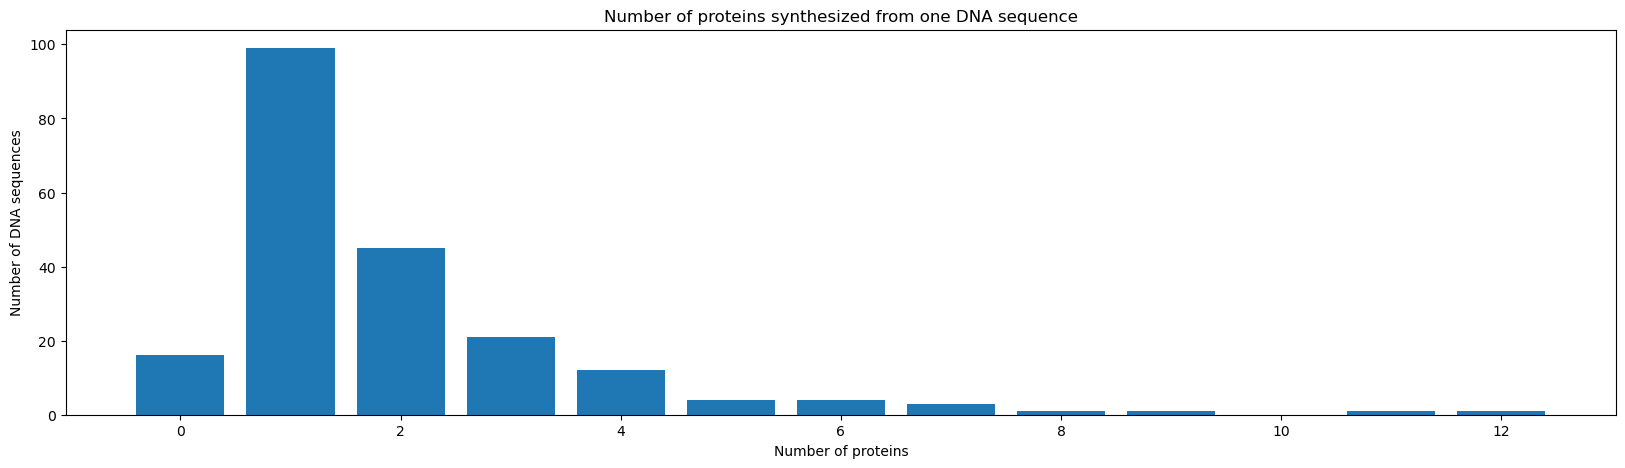

In [14]:
barplot_proteins_number(results_df)

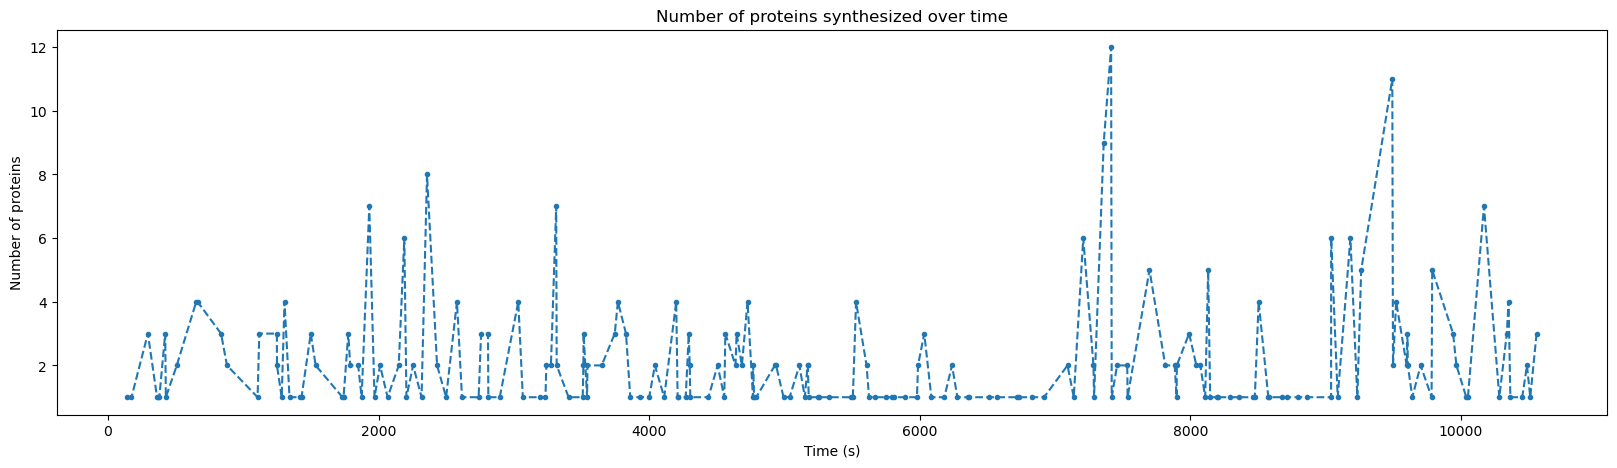

In [15]:
plot_proteins_number_over_time(results_df)

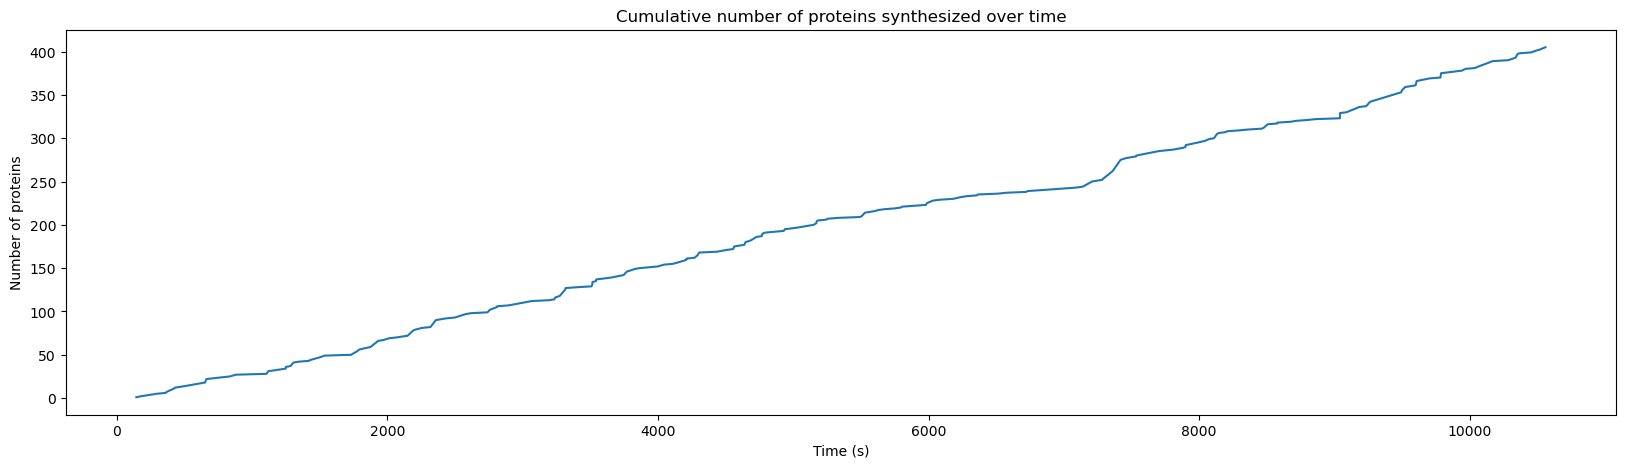

In [16]:
plot_cumulative_proteins_number_over_time(results_df)

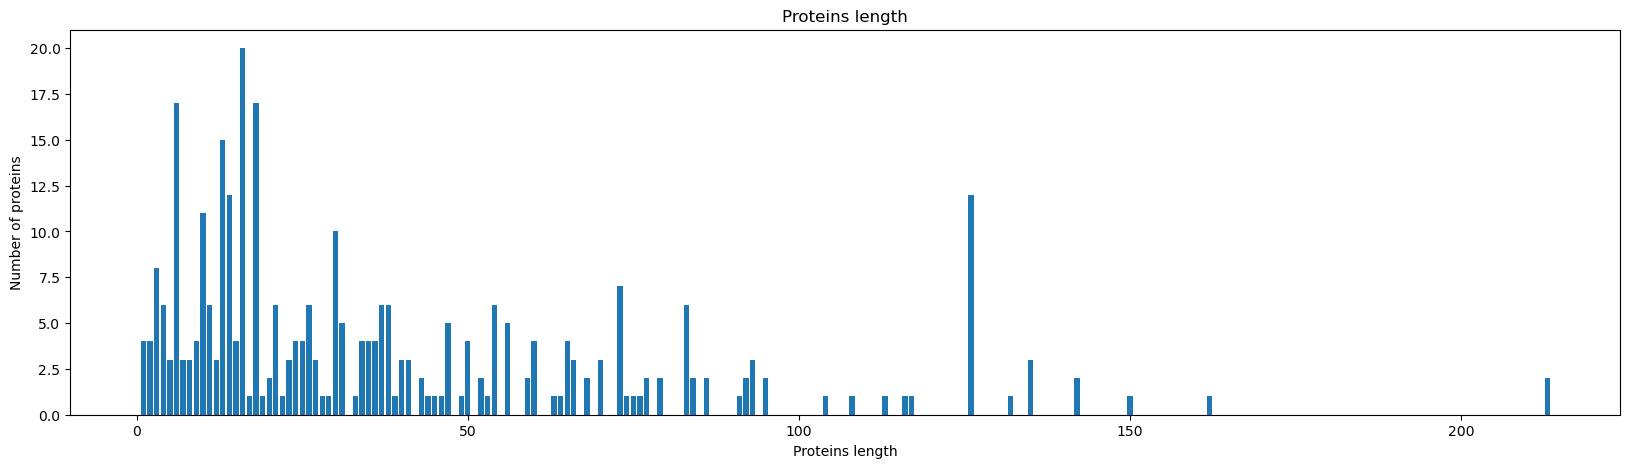

In [17]:
barplot_proteins_length(results_df)

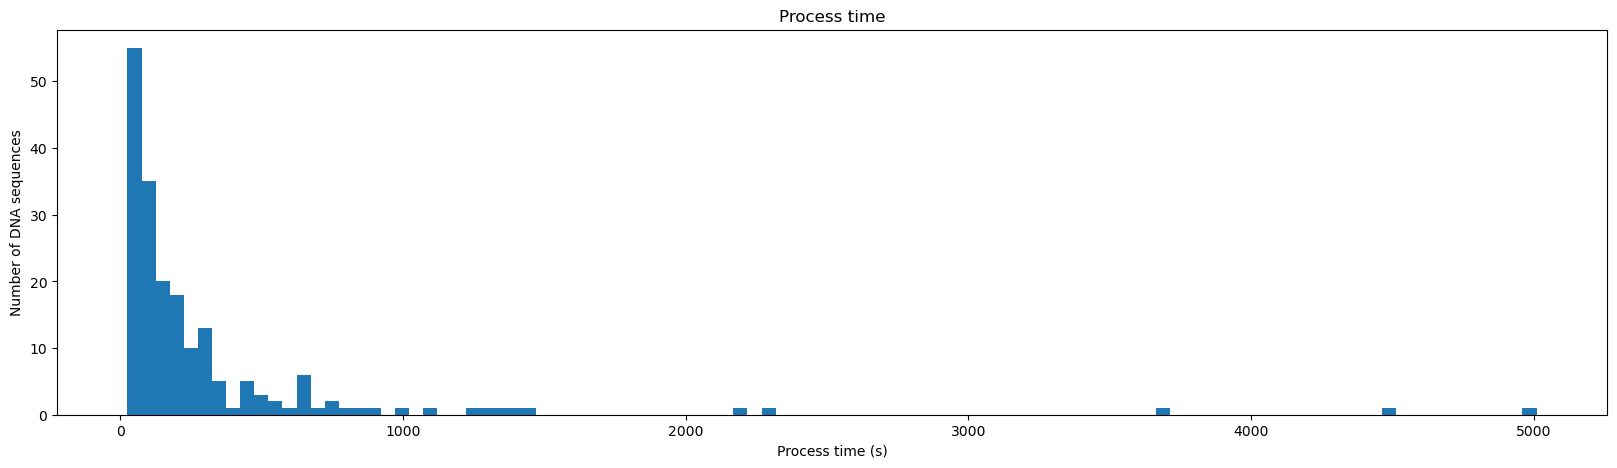

In [18]:
hist_process_time(results_df)

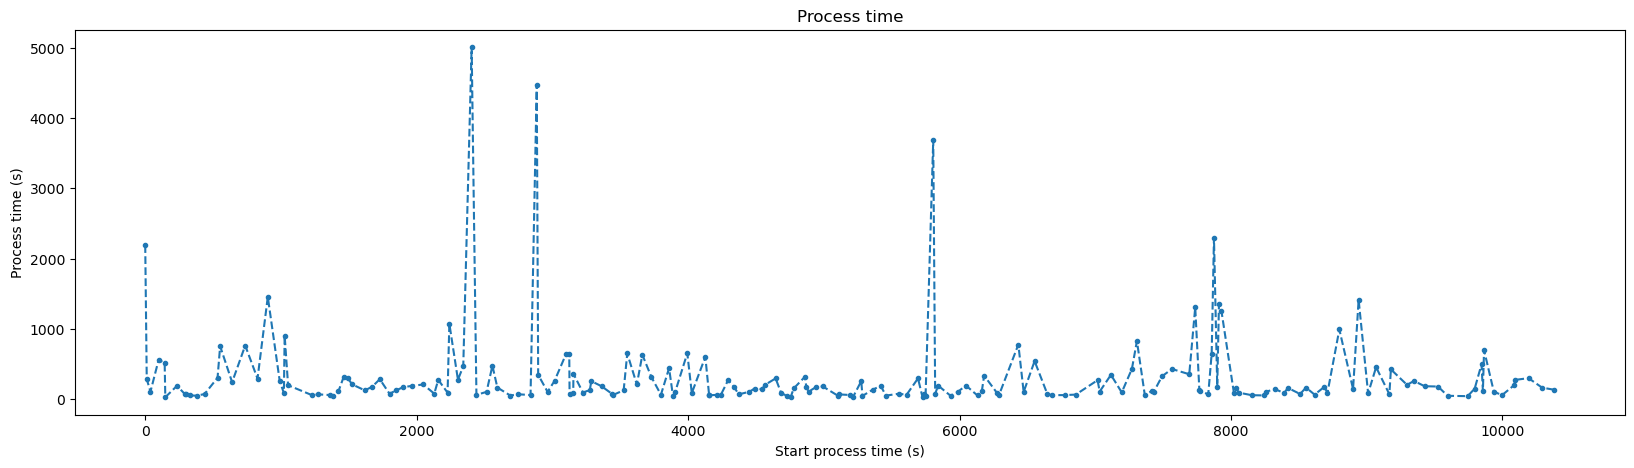

In [19]:
plot_process_time(results_df)

### Nucleotides Level

In [5]:
import json

with open('results/test/nucleotides/nucleotides_history_uracil.json') as f:
    uracil_dict = json.load(f)

with open('results/test/nucleotides/nucleotides_history_adenine.json') as f:
    adenine_dict = json.load(f)

with open('results/test/nucleotides/nucleotides_history_guanine.json') as f:
    guanine_dict = json.load(f)

with open('results/test/nucleotides/nucleotides_history_cytosine.json') as f:
    cytosine_dict = json.load(f)

In [6]:
from src.utils.plot_utils import *

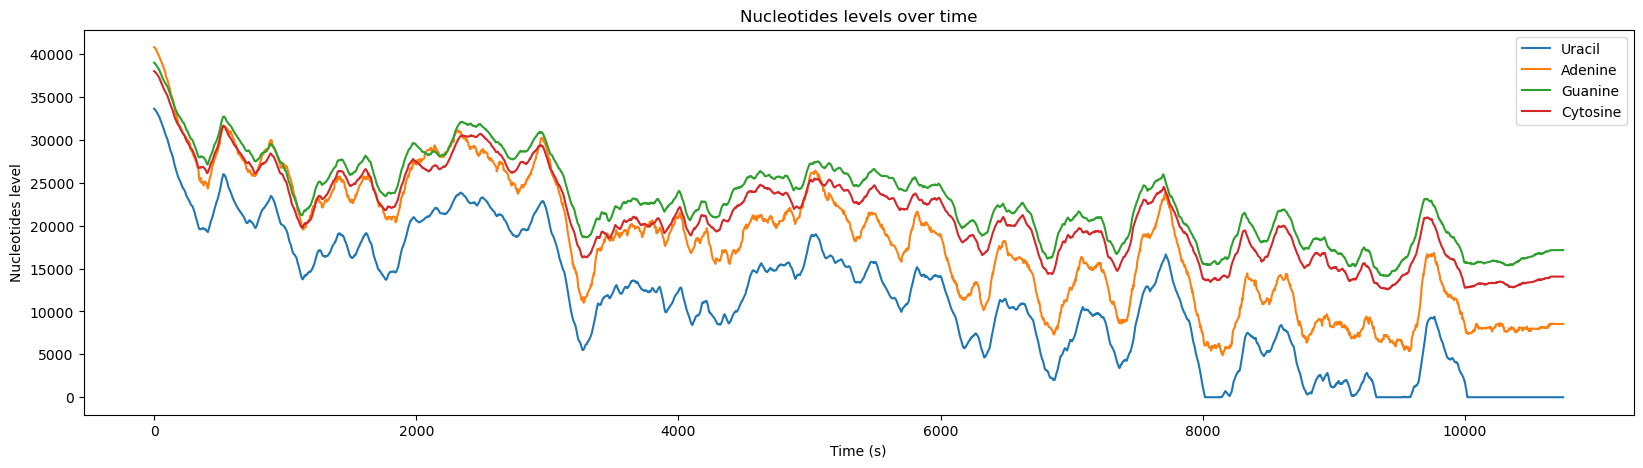

In [7]:
plot_nucleotide_level_over_time(uracil_dict, adenine_dict, guanine_dict, cytosine_dict, time_unit=1)

### RNA Polymerase

In [23]:
with open('results/test/rna_polymerase_history.json') as f:
    rna_polymerase_dict = json.load(f)

In [24]:
rna_polymerase_df = dict_to_dataframe(rna_polymerase_dict)

In [25]:
rna_polymerase_df.describe() # values in seconds

,queue,request_time,available_time,wait_time,end_time,usage_time
count,422.0,422.000000,422.000000,422.0,422.000000,422.000000
mean,0.0,5168.004135,5168.004135,0.0,5323.485766,21.831252
std,0.0,3026.544782,3026.544782,0.0,3060.635946,18.179671
min,0.0,0.000000,0.000000,0.0,92.143100,0.253800
25%,0.0,2608.037600,2608.037600,0.0,2698.718875,7.357000
50%,0.0,4966.786100,4966.786100,0.0,5118.590700,17.927200
75%,0.0,7892.424525,7892.424525,0.0,8095.752350,32.144750
max,0.0,10185.757000,10185.757000,0.0,10564.994500,94.348000


### Ribosome

In [26]:
with open('results/test/ribosome_history.json') as f:
    ribosome_dict = json.load(f)

In [27]:
ribosome_df = dict_to_dataframe(ribosome_dict)

In [28]:
ribosome_df.describe()

,queue,request_time,available_time,wait_time,end_time,usage_time
count,422.0,422.000000,422.000000,422.0,422.000000,422.000000
mean,0.0,5323.485766,5323.485766,0.0,5338.518316,11.373017
std,0.0,3060.635946,3060.635946,0.0,3060.973475,5.350688
min,0.0,92.143100,92.143100,0.0,105.615100,0.078900
25%,0.0,2698.718875,2698.718875,0.0,2712.329375,7.281800
50%,0.0,5118.590700,5118.590700,0.0,5130.764700,12.655000
75%,0.0,8095.752350,8095.752350,0.0,8110.918300,14.531000
max,0.0,10564.994500,10564.994500,0.0,10580.397500,23.837000


Resources request wait time:

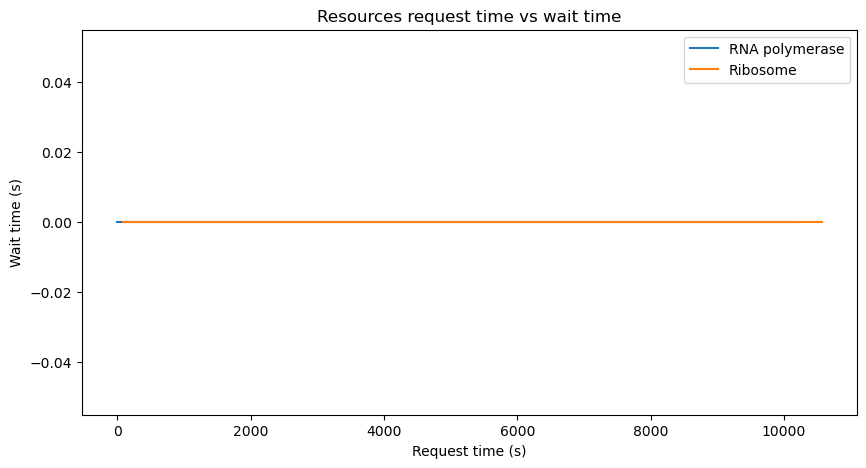

In [29]:
resources_request_wait_time(rna_polymerase_df, ribosome_df)

### Transfer RNA

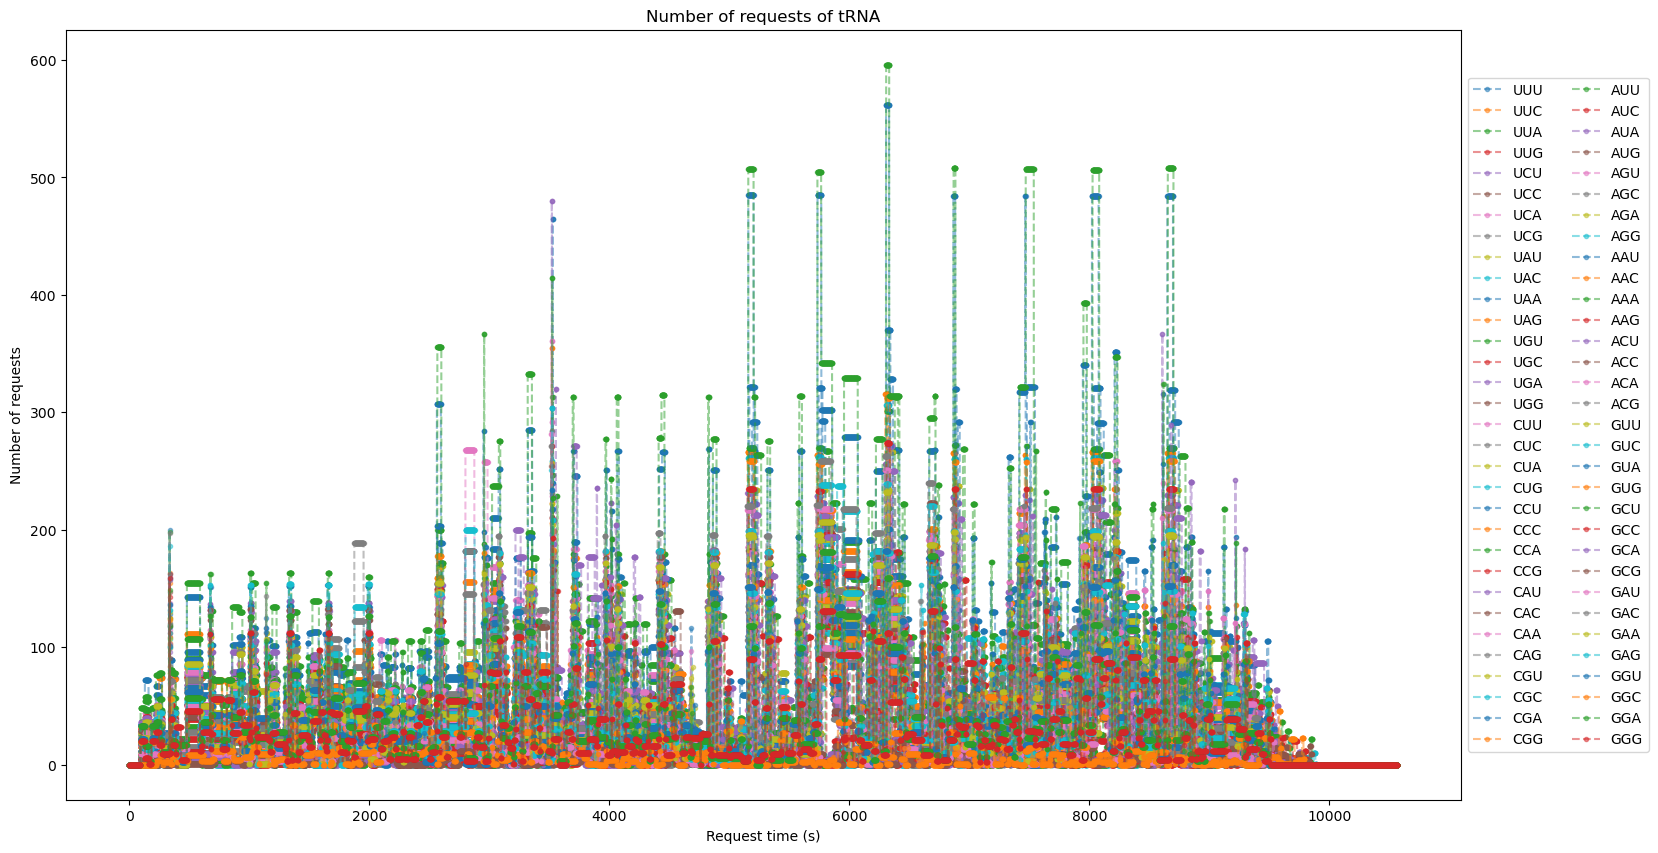

In [30]:
plot_codons_request(file_path='results/test/rna_transfer/', time_unit=1)